<a href="https://colab.research.google.com/github/Neetu24/MicrosoftStockPricePrediction/blob/main/Microsoft_Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-1297457538.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('MSFT', start='2010-01-01', end='2024-12-31')
[*********************100%***********************]  1 of 1 completed


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 52ms/step - loss: 0.0055
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 7.4215e-04
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 7.7424e-04
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - loss: 4.6180e-04
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - loss: 6.2510e-04
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 5.2626e-04
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 4.2707e-04
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 4.0946e-04
Epoch 9/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 4.4200e-04
Epoch 10/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 3.5189e-04
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
🔍 Model Evaluation:
Linear Regression:
MAE: 0.0093
RMSE: 0.0122
R2 Score: 0.9941

Random Forest:
MAE: 0.0833
RMSE: 0.1231
R2 Score: 0.4057

XGBoost:
MAE: 0.0828
RMSE: 0.1253
R2 Score: 0.3842

LSTM:
MAE: 0.0246
RMSE: 0.0310
R2 Score: 0.9627



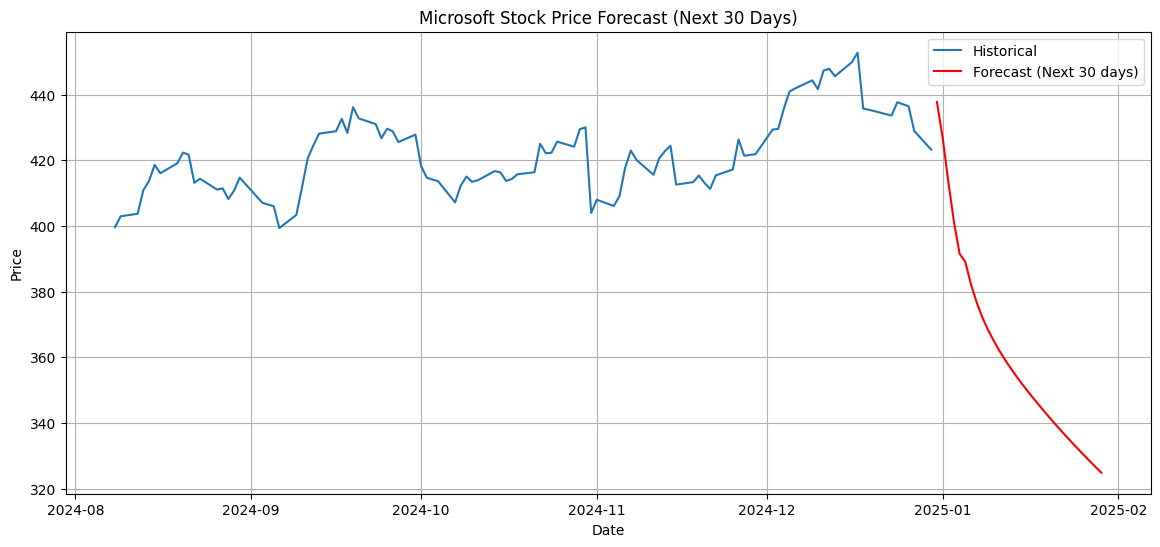

In [ ]:
# 📦 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# 📥 2. Load Dataset
df = yf.download('MSFT', start='2010-01-01', end='2024-12-31')
df.reset_index(inplace=True)

# 🧹 3. Data Preprocessing
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df[['Close', 'Volume']]
df.interpolate(method='linear', inplace=True)

# 📊 4. Feature Engineering
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['STD'] = df['Close'].rolling(window=20).std()
df['Upper'] = df['SMA_20'] + (2 * df['STD'])
df['Lower'] = df['SMA_20'] - (2 * df['STD'])

# RSI Calculation
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

df.dropna(inplace=True)

# 📈 5. Train-Test Split
features = ['Close', 'Volume', 'SMA_20', 'EMA_20', 'Upper', 'Lower', 'RSI']
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

X, y = [], []
for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i])
    y.append(scaled_data[i][0])
X, y = np.array(X), np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# 📘 6. Model 1: Linear Regression
X_lr = scaled_data[:-1]
y_lr = scaled_data[1:, 0]
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(X_lr, y_lr, test_size=0.2, shuffle=False)
lr_model = LinearRegression().fit(X_lr_train, y_lr_train)
lr_pred = lr_model.predict(X_lr_test)

# 📘 7. Model 2: Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_lr_train, y_lr_train)
rf_pred = rf_model.predict(X_lr_test)

# 📘 8. Model 3: XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_lr_train, y_lr_train)
xgb_pred = xgb_model.predict(X_lr_test)

# 📘 9. Model 4: LSTM
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
lstm_pred = model.predict(X_test)

# 🧮 10. Evaluation
def evaluate_model(name, y_true, y_pred):
    print(f"{name}:\nMAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"R2 Score: {r2_score(y_true, y_pred):.4f}\n")

print("🔍 Model Evaluation:")
evaluate_model("Linear Regression", y_lr_test, lr_pred)
evaluate_model("Random Forest", y_lr_test, rf_pred)
evaluate_model("XGBoost", y_lr_test, xgb_pred)
evaluate_model("LSTM", y_test, lstm_pred.flatten())

# 🔮 11. Forecast Next 30 Days with LSTM
last_60 = scaled_data[-60:]
future_preds = []
input_seq = last_60.copy()
for _ in range(30):
    pred = model.predict(input_seq.reshape(1, 60, X.shape[2]), verbose=0)
    future_preds.append(pred[0][0])
    next_input = np.append(input_seq[1:], [[*input_seq[-1][1:], pred[0][0]]], axis=0)
    input_seq = next_input

# 🔁 Inverse transform predicted Close
future_scaled = np.zeros((30, len(features)))
future_scaled[:, 0] = future_preds
future_real = scaler.inverse_transform(future_scaled)[:, 0]

# 📅 Generate Dates
last_date = df.index[-1]
future_dates = pd.date_range(last_date + pd.Timedelta(days=1), periods=30)

# 📉 Plot Forecast
plt.figure(figsize=(14, 6))
plt.plot(df.index[-100:], df['Close'][-100:], label='Historical')
plt.plot(future_dates, future_real, label='Forecast (Next 30 days)', color='red')
plt.title('Microsoft Stock Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
